# Laboratorio 07 - AutoGluon
Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

## Librerías

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

ModuleNotFoundError: No module named 'autogluon'

## Preparación de los datos y Análisis exploratorio

In [2]:
data_path = "./data/diabetes.csv"
data = pd.read_csv(data_path)

print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [3]:
# check missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
# checking zero values
(data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [5]:
# replacing zeros with NaN where it doesn't make sense to have zero
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_to_replace] = data[columns_to_replace].replace(0, pd.NA)

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning, message="Downcasting object dtype arrays on .fillna")

# fill missing values with the median of each column
for column in columns_to_replace:
    median_value = data[column].median(skipna=True)
    data[column] = data[column].fillna(median_value)

In [7]:
# check data types
data.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [8]:
# summary statistics
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


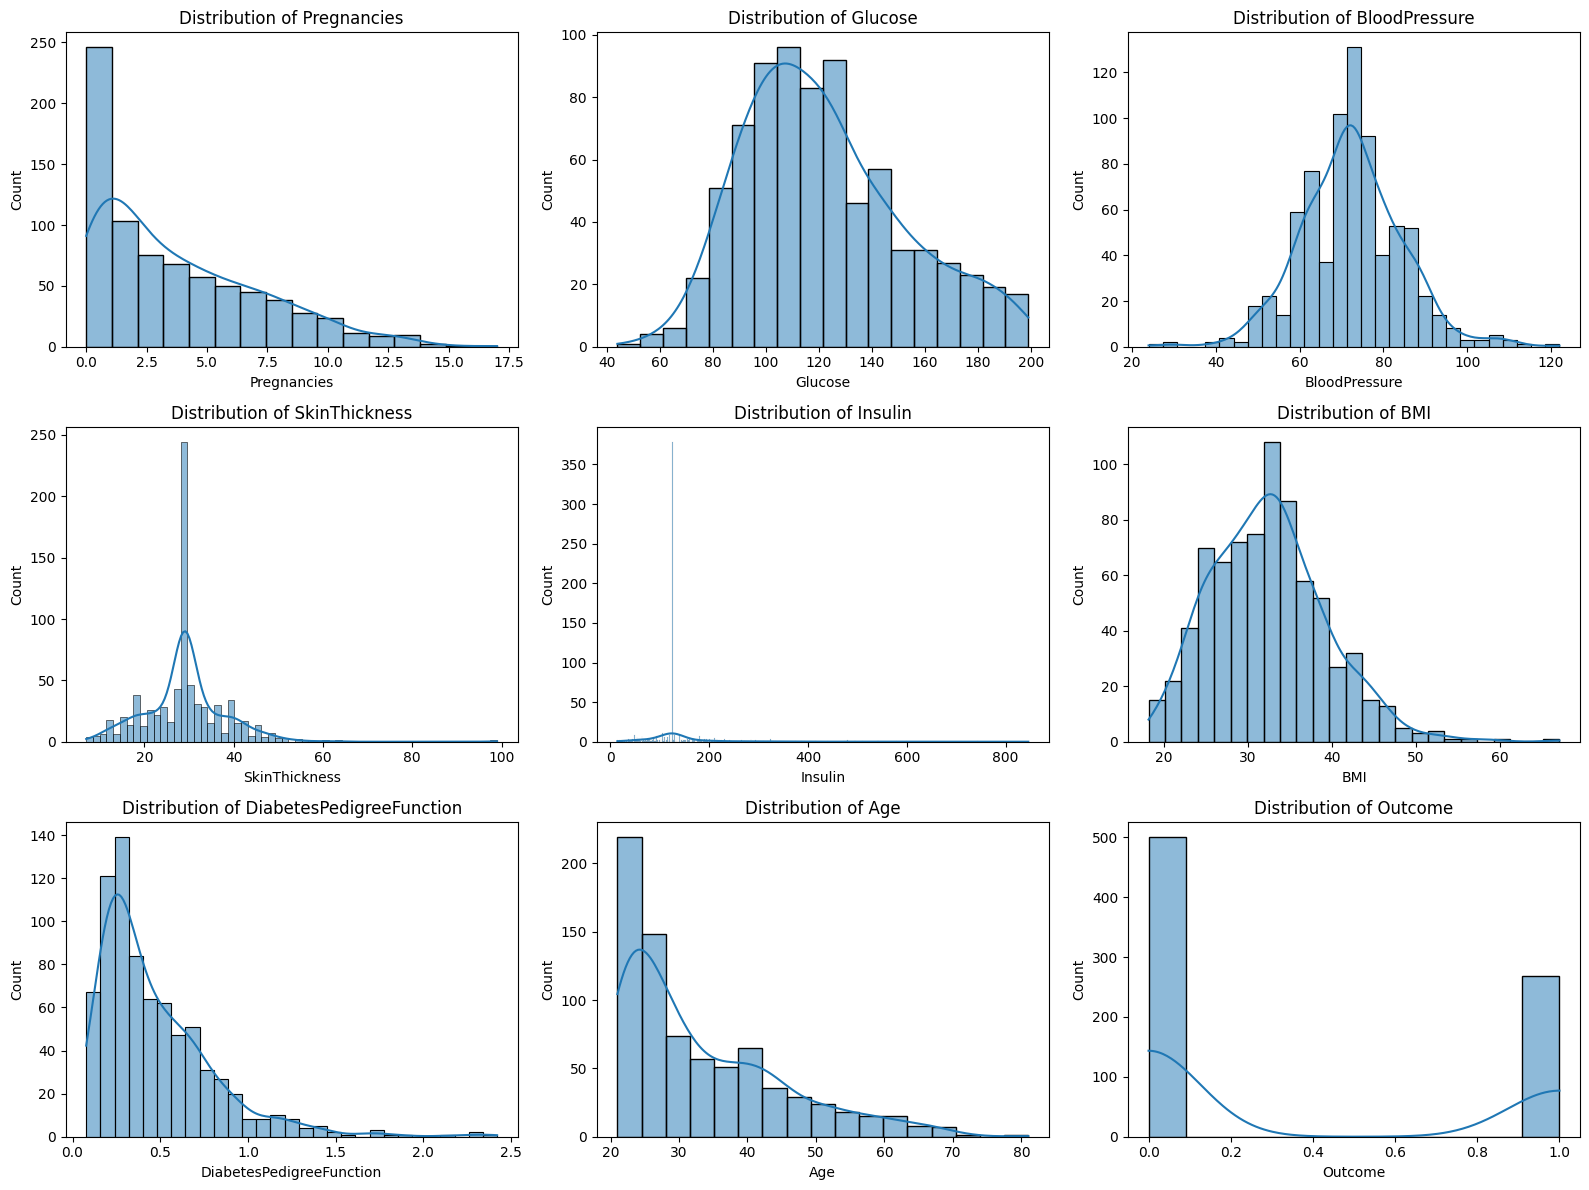

In [9]:
# descriptive statistics
descriptive_statistics = data.describe(include='all')

plt.figure(figsize=(16, 12))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

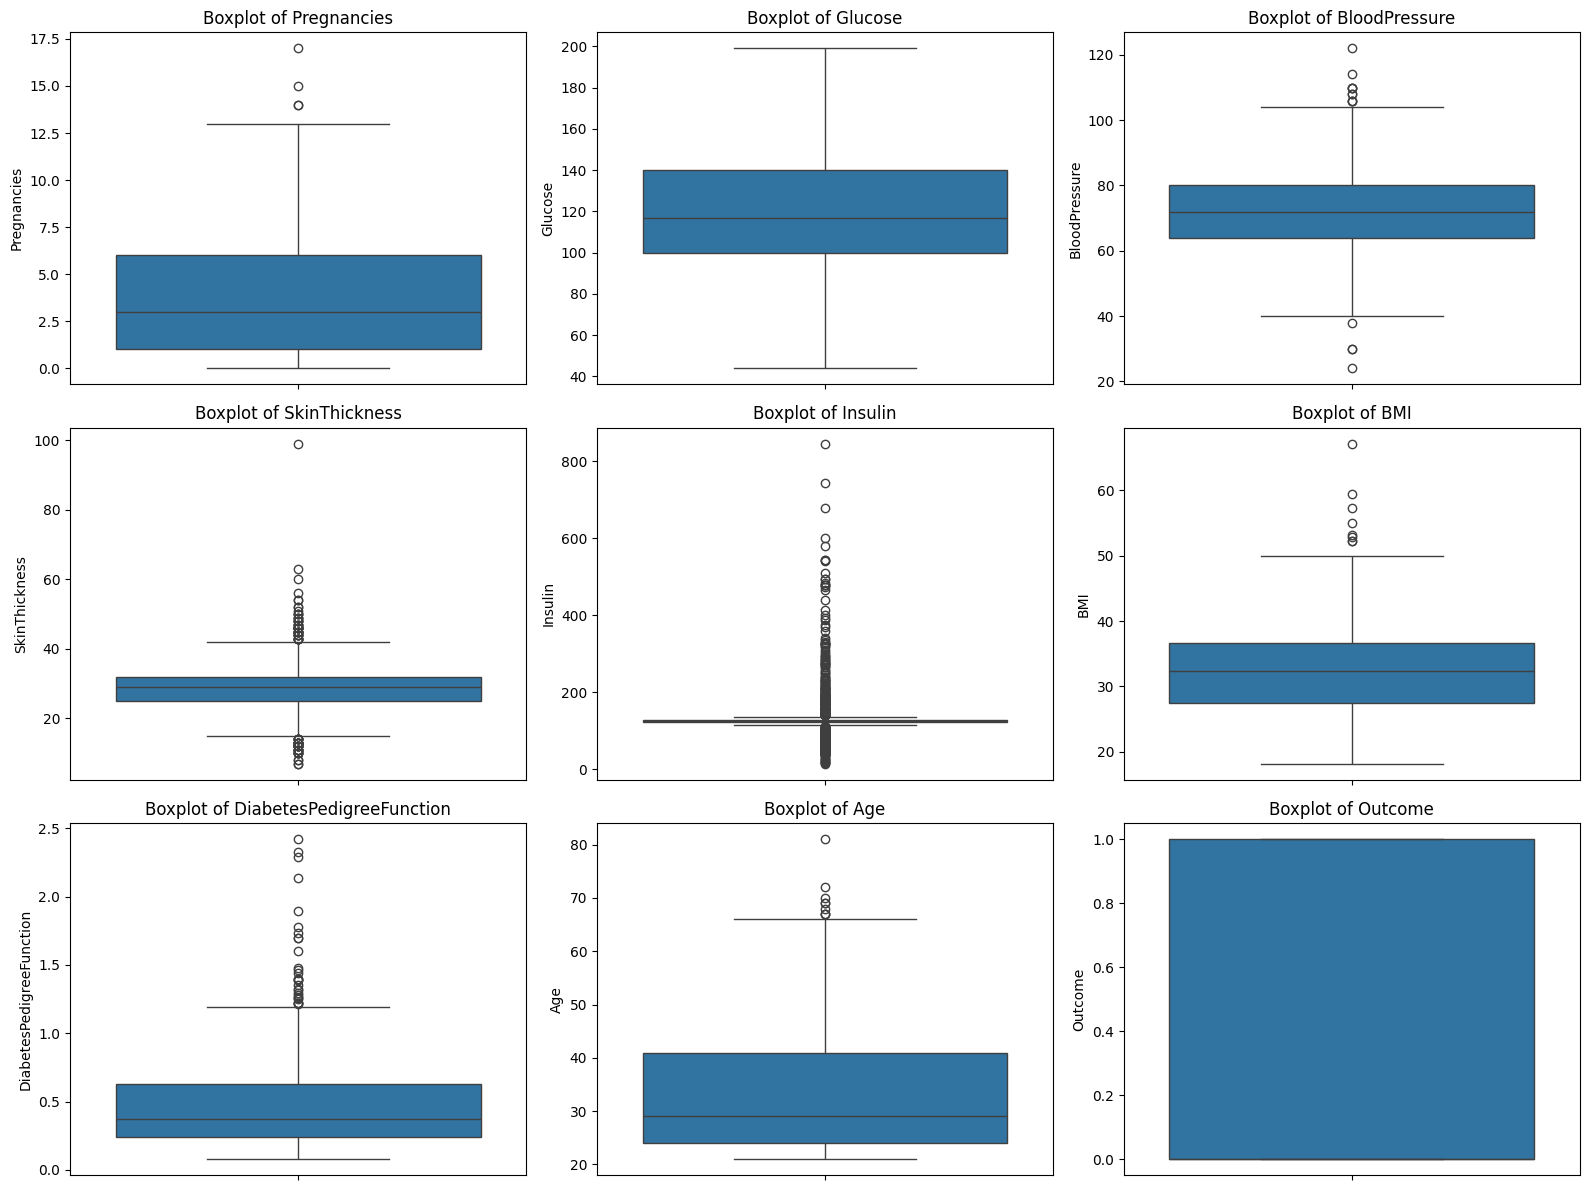

In [10]:
# Visualizing outliers using boxplots
plt.figure(figsize=(16, 12))
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Las **estadísticas descriptivas** se resumen en lo siguiente:
- Pregnancies: Media = 3.85, Desviación estándar = 3.37, Mínimo = 0, Máximo = 17
- Glucose: Media = 121.66, Desviación estándar = 30.44, Mínimo = 44, Máximo = 199
- BloodPressure: Media = 72.39, Desviación estándar = 12.10, Mínimo = 24, Máximo = 122
- SkinThickness: Media = 29.11, Desviación estándar = 8.79, Mínimo = 7, Máximo = 99
- Insulin: Media = 140.67, Desviación estándar = 86.38, Mínimo = 14, Máximo = 846
- BMI: Media = 32.46, Desviación estándar = 6.88, Mínimo = 18.2, Máximo = 67.1
- DiabetesPedigreeFunction: Media = 0.472, Desviación estándar = 0.331, Mínimo = 0.078, Máximo = 2.42
- Age: Media = 33.24, Desviación estándar = 11.76, Mínimo = 21, Máximo = 81
- Outcome: Media = 0.35, Desviación estándar = 0.48, Mínimo = 0, Máximo = 1

En cuanto a los **valores nulos**, no se encuentran presentes en el conjunto de datos. 

Por otro lado, los **valores atípicos**, se muestran en los diagramas de caja y bigotes. Se identifican en las variables como Insulina, Glucosa, Presión Arterial, Grosor de la Piel y BMI. Lo más recomendable sería aplicar _truncamiento_ porque se reemplazan los valores que están más allá de un límite específico. 

### Manejo de valores atípicos

In [11]:
# identified columns with outliers
columns_with_outliers = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 1st and 99th percentiles
percentiles = data[columns_with_outliers].quantile([0.01, 0.99]).to_dict()

# truncating values outside the percentiles
for column in columns_with_outliers:
    lower_bound = percentiles[column][0.01]
    upper_bound = percentiles[column][0.99]
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

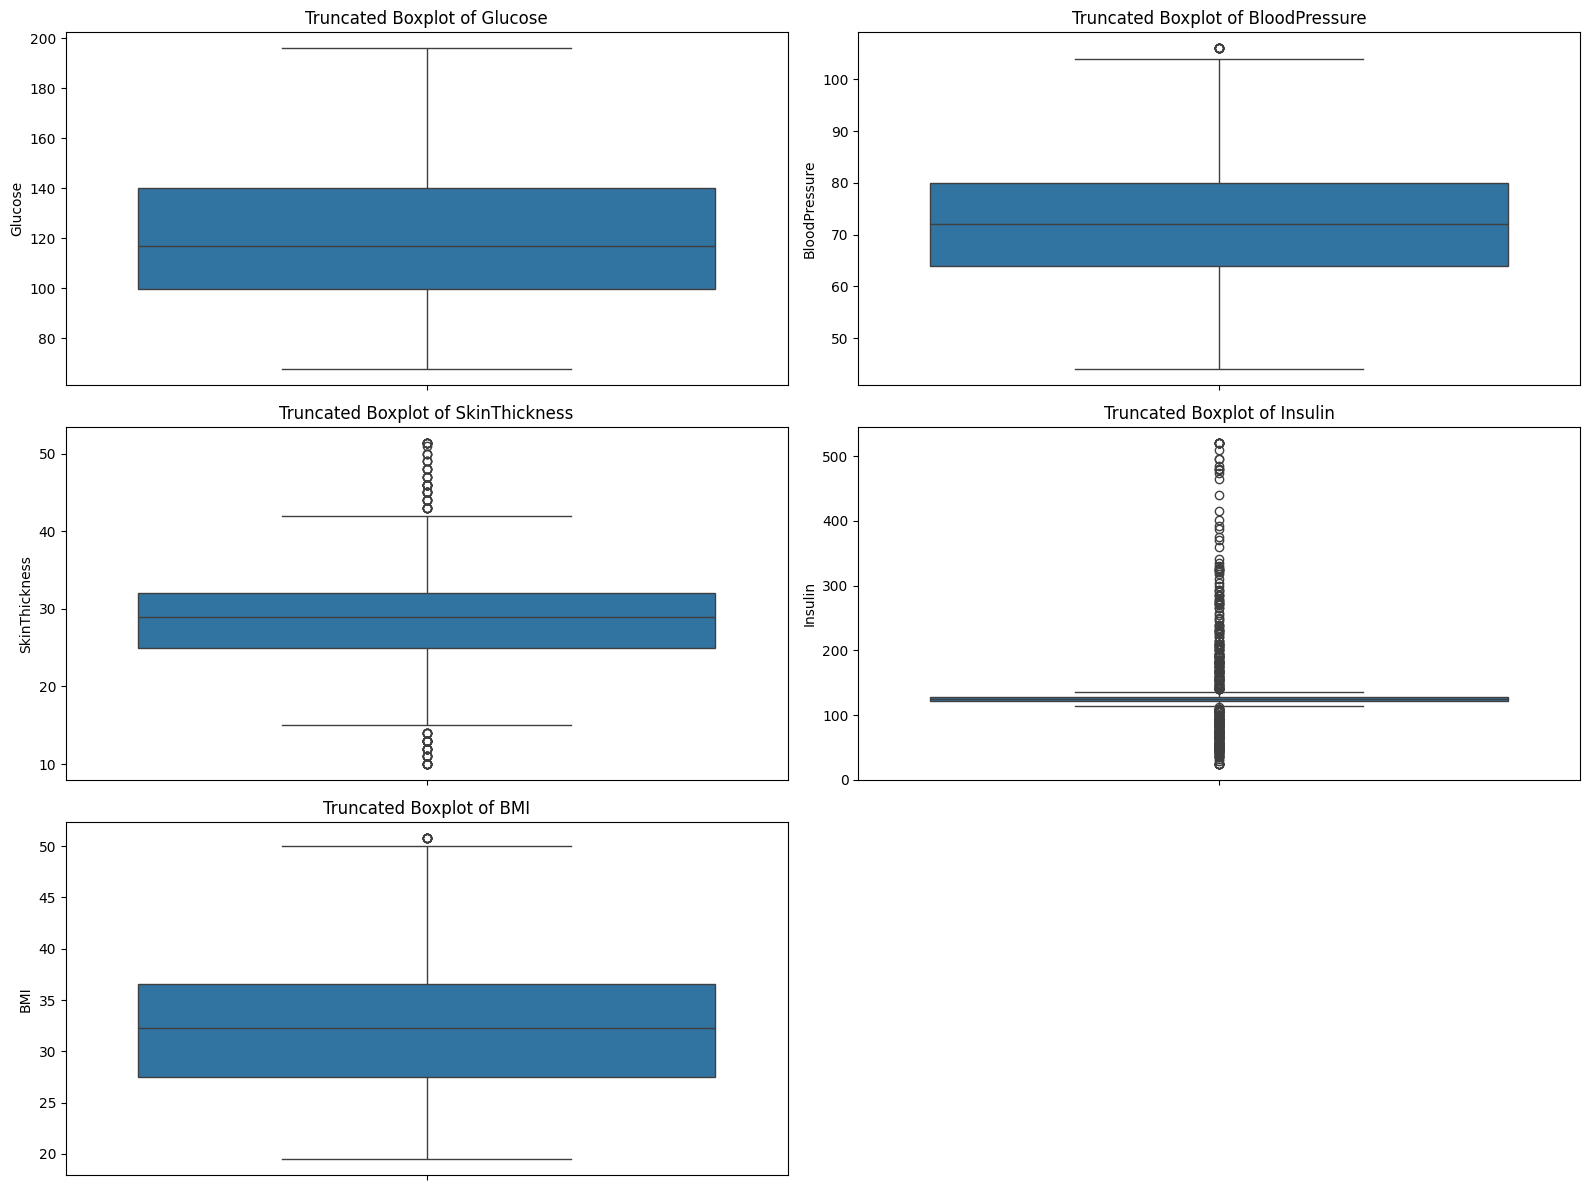

In [12]:
# Visualizing the data after handling outliers
plt.figure(figsize=(16, 12))
for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=data[column])
    plt.title(f'Truncated Boxplot of {column}')

plt.tight_layout()
plt.show()

Como se puede evidenciar, se ha disminuido en gran escala los valores atípicos significativos en las columnas identificadas. Esto ayudará a que el modelo no se vea afectado en su rendimiento con la precencia de estos valores y mejorar la precisión del modelo sin perder información crítica del conjunto de datos.

## Entrenamiento con AutoGluon

In [13]:
warnings.filterwarnings("ignore", category=FutureWarning)

# directory for AutoGluon models
save_path = './models/autogluon_diabetes_models'

# Preparing the data for AutoGluon
label = 'Outcome'
train_data = data.copy()

# Initializing the TabularPredictor
predictor = TabularPredictor(label=label, path=save_path, eval_metric='accuracy').fit(
    train_data,
    presets='best_quality'
)

# Summarize the trained models
leaderboard = predictor.leaderboard(silent=True)
leaderboard

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Tue Sep 24 23:39:07 PDT 2024; root:xnu-11215.1.12~1/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       5.32 GB / 16.00 GB (33.2%)
Disk Space Avail:   260.03 GB / 460.43 GB (56.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. The

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.800781,accuracy,0.038456,14.656259,0.000259,0.055716,2,True,42
1,NeuralNetTorch_r76_BAG_L1,0.799479,accuracy,0.016930,3.166632,0.016930,3.166632,1,True,32
2,NeuralNetTorch_r19_BAG_L1,0.799479,accuracy,0.016953,3.510219,0.016953,3.510219,1,True,39
3,NeuralNetTorch_r41_BAG_L1,0.796875,accuracy,0.018555,6.833102,0.018555,6.833102,1,True,17
4,NeuralNetTorch_r158_BAG_L1,0.794271,accuracy,0.021267,11.433911,0.021267,11.433911,1,True,18
5,NeuralNetTorch_r197_BAG_L1,0.792969,accuracy,0.018070,2.356203,0.018070,2.356203,1,True,19
6,NeuralNetTorch_r86_BAG_L1,0.791667,accuracy,0.019388,5.966623,0.019388,5.966623,1,True,13
7,NeuralNetTorch_r71_BAG_L1,0.789062,accuracy,0.017176,1.787606,0.017176,1.787606,1,True,27
8,NeuralNetTorch_r79_BAG_L1,0.789062,accuracy,0.019672,8.415507,0.019672,8.415507,1,True,8
9,NeuralNetTorch_r22_BAG_L1,0.789062,accuracy,0.020588,8.065989,0.020588,8.065989,1,True,9


## Evaluación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
predictor = TabularPredictor.load(save_path)
predictions = predictor.predict(test_data)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_test = test_data[label]

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

In [ ]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

## Reflexión


Como se puede apreciar, la precisión obtenida con AutoGluon es un valor bastante aceptable. Sin embargo, se puede mejorar el rendimiento del modelo si se realiza un ajuste de hiperparámetros. Tomando esto en cuenta, me gustaría hablar más sobre los AutoML. Yo considero que es una herramienta bastante útil sobre todo a la hora de trabajar con grandes volúmenes de datos o no conocer a fondo el conjunto de datos. Esto es debido a que, como vimos en clase, el AutoML se encarga de realizar todo el proceso de manera automática, desde la limpieza de datos, selección de características, entrenamiento y evaluación del modelo. Sin embargo, en mi opinión, este trabajo debe de ser visto solo como una recomendación propia de la librería, ya que no siempre el modelo que se obtiene es el mejor. Por lo tanto, es importante que se tenga un conocimiento previo del conjunto de datos y se pueda realizar ajustes en el modelo para obtener un mejor rendimiento. Dicho esto, considero que el AutoML es una herramienta bastante útil y que puede ser de gran ayuda en la toma de decisiones, pero siempre se debe de tener en cuenta que no es la solución definitiva y que siempre se puede mejorar.

Es por ello que las principales ventajas de AutoML son la automatización de todo el proceso de modelado, la reducción de tiempo y esfuerzo en la selección de modelos y la mejora en la precisión de los modelos. Sin embargo, las desventajas son que no siempre se obtiene el mejor modelo, la falta de transparencia en el proceso y la necesidad de conocimiento previo para ajustar los modelos. Otro aspecto que me parece interesante a resaltar, es que como vimos en clase, hay muchos modelos que no aprendimos y que gracias a AutoML podemos utilizar. Esto es importante ya que nos permite explorar nuevos modelos y ver cuál se ajusta mejor a nuestro conjunto de datos aún sin tener conocimiento previo de ellos. Tal es el caso del mejor modelo WeightedEnsemble_L2 el cual no conocíamos y que gracias a AutoML se sabe que es el mejor modelo para este conjunto de datos.